# ResNet
- v.1과 동일
- early stopping 횟수를 증가

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

import wandb

In [2]:
wandb.login(key='')
run = wandb.init(project='CV_contest_V10', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [6]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [7]:
class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

In [8]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(600,600), scale=(0.5, 1.0)),
])

simple_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.Resize((600, 600))
])

origin_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
    ])

aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented', transforms=aug_transforms)
aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented2', transforms=aug_transforms)
aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented3', transforms=aug_transforms)
aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented4', transforms=aug_transforms)
aug_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented5', transforms=aug_transforms)
aug_dataset_6 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented6', transforms=aug_transforms)
aug_dataset_7 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented7', transforms=aug_transforms)
aug_dataset_8 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented8', transforms=aug_transforms)
aug_dataset_9 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented9', transforms=aug_transforms)
aug_dataset_10 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/Augmentation/augraphy/augmented10', transforms=aug_transforms)

simple_aug_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_2 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_3 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_4 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_5 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)

origin_dataset_1 = customdataset('/data/ephemeral/home/data/train.csv', '/data/ephemeral/home/data/train/', transforms=origin_transforms)

In [9]:
train_dataset = torch.utils.data.ConcatDataset([aug_dataset_1, aug_dataset_2, aug_dataset_3, 
                                                aug_dataset_4, aug_dataset_5, aug_dataset_6, 
                                                aug_dataset_7, aug_dataset_8, aug_dataset_9, 
                                                aug_dataset_10,

                                                simple_aug_dataset_1, simple_aug_dataset_2, simple_aug_dataset_3,
                                                simple_aug_dataset_4, simple_aug_dataset_5,

                                                origin_dataset_1])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


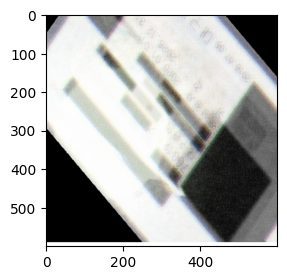

In [10]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[10][0].permute(1, 2, 0))
plt.show()

In [11]:
valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((500, 500))
])

valid_dataset = customdataset('/data/ephemeral/home/preds/minjun_best_score_3.csv', '/data/ephemeral/home/data/test/', transforms=valid_transforms) # valid dataset

In [12]:
len(valid_dataset)

3140

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


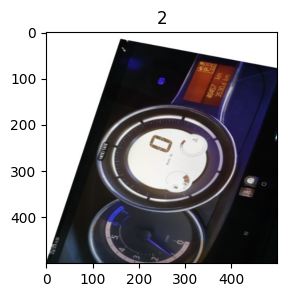

In [13]:
plt.figure(figsize=(3, 3))
plt.imshow(valid_dataset[0][0].permute(1, 2, 0))
plt.title(valid_dataset[0][1])
plt.show()

In [14]:
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

In [15]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v10_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 50:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v10_last.pt")
            print('Early Stopping')
            break

    return model

In [16]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=17
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 500)

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/500], Train Loss: 1.0075, Train Accuracy: 0.6647 Valid Loss: 0.7624, Valid Accuracy: 0.7452


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/500], Train Loss: 0.3325, Train Accuracy: 0.8781 Valid Loss: 0.5936, Valid Accuracy: 0.7949


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/500], Train Loss: 0.2390, Train Accuracy: 0.9140 Valid Loss: 0.7737, Valid Accuracy: 0.7452


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/500], Train Loss: 0.1970, Train Accuracy: 0.9281 Valid Loss: 0.8158, Valid Accuracy: 0.7691


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/500], Train Loss: 0.1456, Train Accuracy: 0.9465 Valid Loss: 0.3749, Valid Accuracy: 0.8790


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/500], Train Loss: 0.1244, Train Accuracy: 0.9558 Valid Loss: 0.5752, Valid Accuracy: 0.8347


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/500], Train Loss: 0.1118, Train Accuracy: 0.9609 Valid Loss: 0.5550, Valid Accuracy: 0.8564


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/500], Train Loss: 0.0927, Train Accuracy: 0.9674 Valid Loss: 0.7152, Valid Accuracy: 0.8188


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/500], Train Loss: 0.0848, Train Accuracy: 0.9713 Valid Loss: 0.4640, Valid Accuracy: 0.8662


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/500], Train Loss: 0.0775, Train Accuracy: 0.9734 Valid Loss: 0.6933, Valid Accuracy: 0.8318


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11/500], Train Loss: 0.0708, Train Accuracy: 0.9752 Valid Loss: 0.4377, Valid Accuracy: 0.8783


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12/500], Train Loss: 0.0647, Train Accuracy: 0.9779 Valid Loss: 0.5217, Valid Accuracy: 0.8764


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13/500], Train Loss: 0.0611, Train Accuracy: 0.9793 Valid Loss: 0.6776, Valid Accuracy: 0.8376


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14/500], Train Loss: 0.0615, Train Accuracy: 0.9789 Valid Loss: 0.4996, Valid Accuracy: 0.8739


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [15/500], Train Loss: 0.0543, Train Accuracy: 0.9803 Valid Loss: 0.6911, Valid Accuracy: 0.8561


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [16/500], Train Loss: 0.0544, Train Accuracy: 0.9816 Valid Loss: 0.4617, Valid Accuracy: 0.8796


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [17/500], Train Loss: 0.0480, Train Accuracy: 0.9829 Valid Loss: 0.6249, Valid Accuracy: 0.8659


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [18/500], Train Loss: 0.0456, Train Accuracy: 0.9850 Valid Loss: 0.9674, Valid Accuracy: 0.8315


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [19/500], Train Loss: 0.0463, Train Accuracy: 0.9836 Valid Loss: 0.5810, Valid Accuracy: 0.8532


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [20/500], Train Loss: 0.0463, Train Accuracy: 0.9842 Valid Loss: 0.5886, Valid Accuracy: 0.8675


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [21/500], Train Loss: 0.0392, Train Accuracy: 0.9862 Valid Loss: 0.5547, Valid Accuracy: 0.8774


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [22/500], Train Loss: 0.0431, Train Accuracy: 0.9847 Valid Loss: 0.7558, Valid Accuracy: 0.8605


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [23/500], Train Loss: 0.0406, Train Accuracy: 0.9860 Valid Loss: 0.5533, Valid Accuracy: 0.8736


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [24/500], Train Loss: 0.0373, Train Accuracy: 0.9878 Valid Loss: 0.6814, Valid Accuracy: 0.8615


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [25/500], Train Loss: 0.0399, Train Accuracy: 0.9855 Valid Loss: 0.6545, Valid Accuracy: 0.8580


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [26/500], Train Loss: 0.0337, Train Accuracy: 0.9876 Valid Loss: 0.7841, Valid Accuracy: 0.8459


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [27/500], Train Loss: 0.0364, Train Accuracy: 0.9875 Valid Loss: 1.8485, Valid Accuracy: 0.7592


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [28/500], Train Loss: 0.0472, Train Accuracy: 0.9840 Valid Loss: 0.6690, Valid Accuracy: 0.8618


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [29/500], Train Loss: 0.0380, Train Accuracy: 0.9878 Valid Loss: 0.6031, Valid Accuracy: 0.8732


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [30/500], Train Loss: 0.0301, Train Accuracy: 0.9898 Valid Loss: 0.8668, Valid Accuracy: 0.8252


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [31/500], Train Loss: 0.0296, Train Accuracy: 0.9901 Valid Loss: 0.6123, Valid Accuracy: 0.8691


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [32/500], Train Loss: 0.0280, Train Accuracy: 0.9902 Valid Loss: 0.6278, Valid Accuracy: 0.8780


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [33/500], Train Loss: 0.0260, Train Accuracy: 0.9909 Valid Loss: 0.8564, Valid Accuracy: 0.8611


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [34/500], Train Loss: 0.0337, Train Accuracy: 0.9882 Valid Loss: 0.6997, Valid Accuracy: 0.8732


  0%|          | 0/252 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Submission

In [5]:
model = timm.create_model(
    'resnet34',
    pretrained=True,
    num_classes=17
).to(device)
model.load_state_dict(torch.load('/data/ephemeral/home/model/models/model_v10_best.pt'))
criterion = torch.nn.CrossEntropyLoss()

In [6]:
class sub_customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [7]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
])

sub_dataset = sub_customdataset('/data/ephemeral/home/data/sample_submission.csv', '/data/ephemeral/home/data/test/', transforms=transforms)

In [8]:
batch_size = 64

sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [9]:
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    tbar = tqdm(sub_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        max_prob, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted)
        all_labels.extend(labels)
        all_images.extend(images)


  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [10]:
all_preds

[tensor(2, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(2, device='cuda:0')

In [11]:
sub_df = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv')
sub_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [12]:
for i in range(3140):
    sub_df.iloc[i, 1] = int(all_preds[i].cpu())

In [13]:
cnt_list = []
for i in range(17):
    cnt_list.append(sub_df[sub_df['target']==i].shape[0])

cnt_list

[199,
 84,
 200,
 253,
 177,
 198,
 175,
 157,
 201,
 199,
 208,
 197,
 226,
 154,
 107,
 205,
 200]

In [14]:
sub_df.to_csv('/data/ephemeral/home/preds/v10_preds.csv', index=False)